# Вебинар 3. Коллаборативная фильтрация

Исчерпывающую информацию с теорией, кодом и примерами можно найти в [статье](https://www.ethanrosenthal.com/2016/10/19/implicit-mf-part-1/)

**Эвристические алгоритмы** еще в этой схеме - простейшие алгоритмы. Используют простые эвристики, например, давайте рекомендовать то, что популярно.

**Коллаборативные алгоритмы.** Связаны с разложением матриц. User-based и Item-based. Это алгоритмы, которые исключительно связаны с айтемами (не с признаками объектов).

**Контентные алгоритмы.** Основаны чисто на свойствах (признаках) пользователя. Например, стоит в профиле "люблю боевики" - рекомендуем "Команда А".

**Гибридные алгоритмы** соответственно основаны и на айтемах, и на признаках.

Collaborative matrix делится на User-Based matrix и Item-Based matrix по идее

# 1. Матричная факторизация / Матричные разложения

Вся сила в взвешивании

Раскладываем user-item матрицу на 2: матрицу латентных факторов юзеров и матрицу латентных факторов товаров

- латентый фактор = эмбеддинг (embedding)    

Как можно разбить матрицу из трех на матрицы юзеров и матрицу итемов:

$$\Large S_{(m,n)} = U_{(m,k)} \cdot \Sigma_{(k,k)} \cdot V_{(k,n)} = U_{(m,k)} \cdot \Sigma_{u,(k,k)} \cdot \Sigma_{v,(k,k)} \cdot V_{(k,n)} = U_{(m,k)}^{'} \cdot V_{(k,n)}^{'}$$

S(m,n) => X(n,n), S(m,n) @ X(n,n) = S'(m,n)

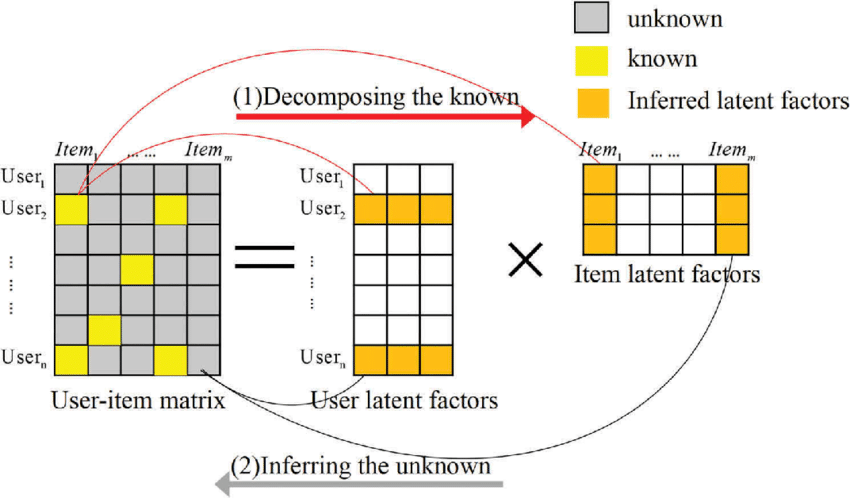

(UхI) = (Uхk) * (kхI) 

---

## Alternating Least Squares (ALS)

SVD разложение делать довольно сложно и оно не всегда параллелится. Поэтому рассмотрим более оптимальный вариант разложения Alternating Least Squares (ALS)

Как находятся матрицы Users и Movies? 

- Заполнение рандомными числами
- Фиксируем одну матрицу, например Movies
- Далее ищем Users (как-то)
- Фиксируем Users
- Находим оптимальное решение для матрицы Movies 

И так делаем поочереди, итерационно. Поэтому и метод называется Alternating (поочередный)

![als](images/als.png "als")

**ALS(explicit)**

Явный отклик.

r - рейтинги <br>
p - вектор-пользователь <br>
q - вектор-айтем <br>

Мы подбираем такие вектора, чтобы $L$ была минимальной (это как ошибка, вспоминаем GD).

Если мы q будем фиксировать, то $L$ превращается в линейную регрессию с регуляризацией  $L_{2}$

Поиск весов по МНК

![als_explicit](images/als_explicit.png "als_explicit")

Фиксируя поочередно p и q, найдем вектора p и q + ошибка $L$ будет минимизироваться.

Перемножая матрицы User-Based ($U_i$) и Item-Based ($V^T$) получим рейтинги, скоры

В варианте explicit у нас на откликах 0 или 1, или вообще неизвестно. А нам хочется получить какое-то приближение матрицы, ведь у нас исходная - разряженная матрица. И в случае с implicit у нас будет другая функция потерь $L$.

**ALS(implicit)**

Неявный отклик

![als_implicit](images/als_implicit.png "als_implicit")

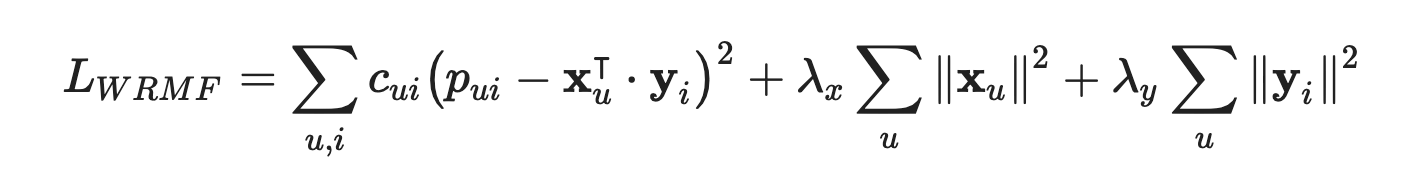

$x_u^T$ - user embeddings  
$y_i$ - item embeddings  
$p_{ui}$ - 0/1. 1 - если в матрице user-item эдемент > 0 (было взаимодействие)  
$c_{ui}$ - Вес ошибки = элемент матрицы user-item  
$\lambda_x$, $\lambda_y$ - коэффициенты регуляризации  

**Алгоритм**  
ALS - лишь способ оптимизации (поиска коэффициентов в эмбеддингах):  

1. Фиксируем эмбеддинги юзеров $x_u^T$ --> легко посчитать производную по эмбеддингам товаров $y_i$
2. Обновляем эмбеддинги товаров (делаем шаг по антиградиенту = градиентный спуск)
3. Фиксируем эмбеддинги товаров $y_i$ --> легко посчитать производную по эмбеддингам юзеров $x_u^T$
4. Обновляем эмбеддинги юзеров (делаем шаг по антиградиенту = градиентный спуск)
5. Повторяем, пока процедура не сойдется

**Плюсы**
- Очень быстрый
- В продакшене можно зафиксировать на весь день эмбеддинги товаров (товары за день не меняются), 
    и в реал-тайм обновлять эмбеддинги юзеров при покупке
- Есть регуляризация $\lambda_x$, $\lambda_y$
- Есть веса ошибок $с_{u_i}$ - элементы матрицы user-item
- Библиотека implicit под капотом использует Cyton - очень быстро работает
- Predict для *всех* юзеров можно сделать прост оперемножением 2-ух матриц - очень быстро
- Можно применять различные **взвешивания** матрицы: TF-IDF, BM25, ... . Это сильно улучшает качество

### 1. Базовое применение

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix

# Матричная факторизация
from implicit.als import AlternatingLeastSquares
from implicit.nearest_neighbours import bm25_weight, tfidf_weight

In [2]:
# Функции из 1-ого вебинара
def precision_at_k(recommended_list, bought_list, k=5):
    bought_list = np.array(bought_list)
    recommended_list = np.array(recommended_list)
    
    bought_list = bought_list 
    recommended_list = recommended_list[:k]
    flags = np.isin(bought_list, recommended_list)
    precision = flags.sum() / len(recommended_list)
    
    return precision

def recall_at_k(recommended_list, bought_list, k=5):
    bought_list = np.array(bought_list)
    recommended_list = np.array(recommended_list)
    
    flags = np.isin(bought_list, recommended_list[:k])
    recall = flags.sum() / len(bought_list)
    
    return recall

In [3]:
data = pd.read_csv('retail_train.csv')

data.columns = [col.lower() for col in data.columns]
data.rename(columns={'household_key': 'user_id',
                    'product_id': 'item_id'},
           inplace=True)


test_size_weeks = 3

data_train = data[data['week_no'] < data['week_no'].max() - test_size_weeks]
data_test = data[data['week_no'] >= data['week_no'].max() - test_size_weeks]

data_train.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0


In [4]:
item_features = pd.read_csv('product.csv')
item_features.columns = [col.lower() for col in item_features.columns]
item_features.rename(columns={'product_id': 'item_id'}, inplace=True)

item_features.head(2)

,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,


In [5]:
item_features.department.unique()

array(['GROCERY', 'MISC. TRANS.', 'PASTRY', 'DRUG GM', 'MEAT-PCKGD',
       'SEAFOOD-PCKGD', 'PRODUCE', 'NUTRITION', 'DELI', 'COSMETICS',
       'MEAT', 'FLORAL', 'TRAVEL & LEISUR', 'SEAFOOD', 'MISC SALES TRAN',
       'SALAD BAR', 'KIOSK-GAS', 'ELECT &PLUMBING', 'GRO BAKERY',
       'GM MERCH EXP', 'FROZEN GROCERY', 'COUP/STR & MFG', 'SPIRITS',
       'GARDEN CENTER', 'TOYS', 'CHARITABLE CONT', 'RESTAURANT', 'RX',
       'PROD-WHS SALES', 'MEAT-WHSE', 'DAIRY DELI', 'CHEF SHOPPE', 'HBC',
       'DELI/SNACK BAR', 'PORK', 'AUTOMOTIVE', 'VIDEO RENTAL', ' ',
       'CNTRL/STORE SUP', 'HOUSEWARES', 'POSTAL CENTER', 'PHOTO', 'VIDEO',
       'PHARMACY SUPPLY'], dtype=object)

In [6]:
result = data_test.groupby('user_id')['item_id'].unique().reset_index()
result.columns=['user_id', 'actual']
result.head(2)

,user_id,actual
0,1,"[821867, 834484, 856942, 865456, 889248, 90795..."
1,3,"[835476, 851057, 872021, 878302, 879948, 90963..."


In [7]:
popularity = data_train.groupby('item_id')['quantity'].sum().reset_index()
popularity.rename(columns={'quantity': 'n_sold'}, inplace=True)

top_5000 = popularity.sort_values('n_sold', ascending=False).head(5000).item_id.tolist()

In [8]:
# Заведем фиктивный item_id (если юзер покупал товары из топ-5000, то он "купил" такой товар)
data_train.loc[~data_train['item_id'].isin(top_5000), 'item_id'] = 999999

user_item_matrix = pd.pivot_table(data_train, 
                                  index='user_id', columns='item_id', 
                                  values='quantity', # Можно пробоват ьдругие варианты
                                  aggfunc='count', 
                                  fill_value=0
                                 )

user_item_matrix = user_item_matrix.astype(float) # необходимый тип матрицы для implicit

# переведем в формат saprse matrix
sparse_user_item = csr_matrix(user_item_matrix).tocsr()

user_item_matrix.head(3)

item_id,202291,397896,420647,480014,545926,707683,731106,818980,819063,819227,...,15778533,15831255,15926712,15926775,15926844,15926886,15927403,15927661,15927850,16809471
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
userids = user_item_matrix.index.values
itemids = user_item_matrix.columns.values

matrix_userids = np.arange(len(userids))
matrix_itemids = np.arange(len(itemids))

id_to_itemid = dict(zip(matrix_itemids, itemids))
id_to_userid = dict(zip(matrix_userids, userids))

itemid_to_id = dict(zip(itemids, matrix_itemids))
userid_to_id = dict(zip(userids, matrix_userids))

Еще раз в чем идея. Мы создаем латентные матрицы юзеров и айтемов, в которых каждому юзеру и айтему будет соответствовать вектор длины $k$ (factors). Когда мы их создадим, то перемножив получим рейтинг взаимодействия **User-Item matrix** соответственно.

In [10]:
%%time

model = AlternatingLeastSquares(factors=100, # длина вектора латентного пространства (юзеров и айтемов)
                                regularization=0.001, # регуляризация
                                iterations=15, # фиксируем матрицу, считаем вторую и т.д. так 15 раз
                                calculate_training_loss=True, 
                                num_threads=4,
                                random_state=42)

model.fit(sparse_user_item, # На вход item-user matrix
          show_progress=True)

recs = model.recommend(userid=userid_to_id[2],  # userid - id от 0 до N
                        user_items=sparse_user_item,   # на вход user-item matrix
                        N=5, # кол-во рекомендаций 
                        filter_already_liked_items=False, 
                        filter_items=[itemid_to_id[999999]],
                        recalculate_user=False) # здесь параметр важен. 

  0%|          | 0/15 [00:00<?, ?it/s]

CPU times: total: 16.4 s
Wall time: 2.35 s


In [11]:
[id_to_itemid[rec] for rec in recs[0]]

[1106523, 1133018, 5569230, 1082185, 1068719]

Посчитали рекомендации для юзера с id=2. Теперь для всех

In [12]:
def get_recommendations(user, model, sparse_user_item, N=5):
    res = [id_to_itemid[rec] for rec in 
                    model.recommend(userid=userid_to_id[user], 
                                    user_items=sparse_user_item[userid_to_id[user]],   # на вход user-item matrix
                                    N=N, 
                                    filter_already_liked_items=False, 
                                    filter_items=[itemid_to_id[999999]], 
                                    recalculate_user=True)[0]] 
    return res

Почему recalculate_user=True? Допустим мы посчитали матрицу и появился новый пользователь. Что делать? Считать все заново - нет. Достаточно пересчитать только 1 вектор. Если True, то вектор для пользователя будет заново посчитан. В user_items оставляем строчку, которая соответствует пользователю

In [13]:
%%time
    
result['als'] = result['user_id'].apply(lambda x: get_recommendations(x, model, sparse_user_item, N=5))
result.apply(lambda row: precision_at_k(row['als'], row['actual']), axis=1).mean()

CPU times: total: 6.92 s
Wall time: 2.13 s


0.180411361410382

In [14]:
result.head(2)

,user_id,actual,als
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[1105488, 1033142, 5569374, 979707, 995242]"
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...","[1106523, 1133018, 910032, 5569327, 1022003]"


### Embeddings

In [15]:
model.item_factors.shape

(5001, 100)

In [16]:
model.user_factors.shape

(2499, 100)

Можно очень быстро посчитать предсказания, перемножив эти 2 матрицы

In [17]:
fast_recs = model.user_factors @ model.item_factors.T
fast_recs.shape

(2499, 5001)

In [18]:
fast_recs[:5, :5]

array([[-0.01285826,  0.13209045, -0.00667117, -0.04873276,  0.00837926],
       [-0.00267927,  0.0429156 , -0.01870282, -0.00473014, -0.00799388],
       [-0.02074427, -0.0993469 , -0.03176264, -0.04435883, -0.01701099],
       [ 0.00708636,  0.06434218,  0.04744274,  0.0427931 ,  0.0027308 ],
       [ 0.00129691,  0.03597947, -0.01374792,  0.03642482,  0.00341381]],
      dtype=float32)

В чем еще плюсы данного разложения?

Есть методы понижения размерности PCA, TSNE, дабы оставить только самые полезные. 

Берем матрицу товаров, которую мы получили в результате модели, попробуем размерность до 2х и попробуем как товары будут отражаться на плоскости. И еще каждому товару в зависимости от категории покрасим его в какой-то цвет.

In [19]:
import numpy as np
import pandas as pd
from matplotlib.pyplot import cm
import pickle

from scipy.spatial.distance import cdist

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import seaborn as sns


def reduce_dims(df, dims=2, method='pca'):
    
    assert method in ['pca', 'tsne'], 'Неверно указан метод'
    
    if method=='pca':
        pca = PCA(n_components=dims)
        components = pca.fit_transform(df)
    elif method == 'tsne':
        tsne = TSNE(n_components=dims, learning_rate=250, random_state=42)
        components = tsne.fit_transform(df)
    else:
        print('Error')
        
    colnames = ['component_' + str(i) for i in range(1, dims+1)]
    return pd.DataFrame(data = components, columns = colnames) 


def display_components_in_2D_space(components_df, labels='category', marker='D'):
    
    groups = components_df.groupby(labels)

    # Plot
    fig, ax = plt.subplots(figsize=(12,8))
    ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
    for name, group in groups:
        ax.plot(group.component_1, group.component_2, 
                marker='o', ms=6,
                linestyle='',
                alpha=0.7,
                label=name)
    ax.legend(loc='center left', bbox_to_anchor=(1.02, 0.5))

    plt.xlabel('component_1')
    plt.ylabel('component_2') 
    plt.show()

In [20]:
model.item_factors.shape

(5001, 100)

In [21]:
category = []

for idx in range(model.item_factors.shape[0]):

    try:
        cat = item_features.loc[item_features['item_id'] == id_to_itemid[idx], 'department'].values[0]
        category.append(cat)
    except:
        category.append('UNKNOWN')

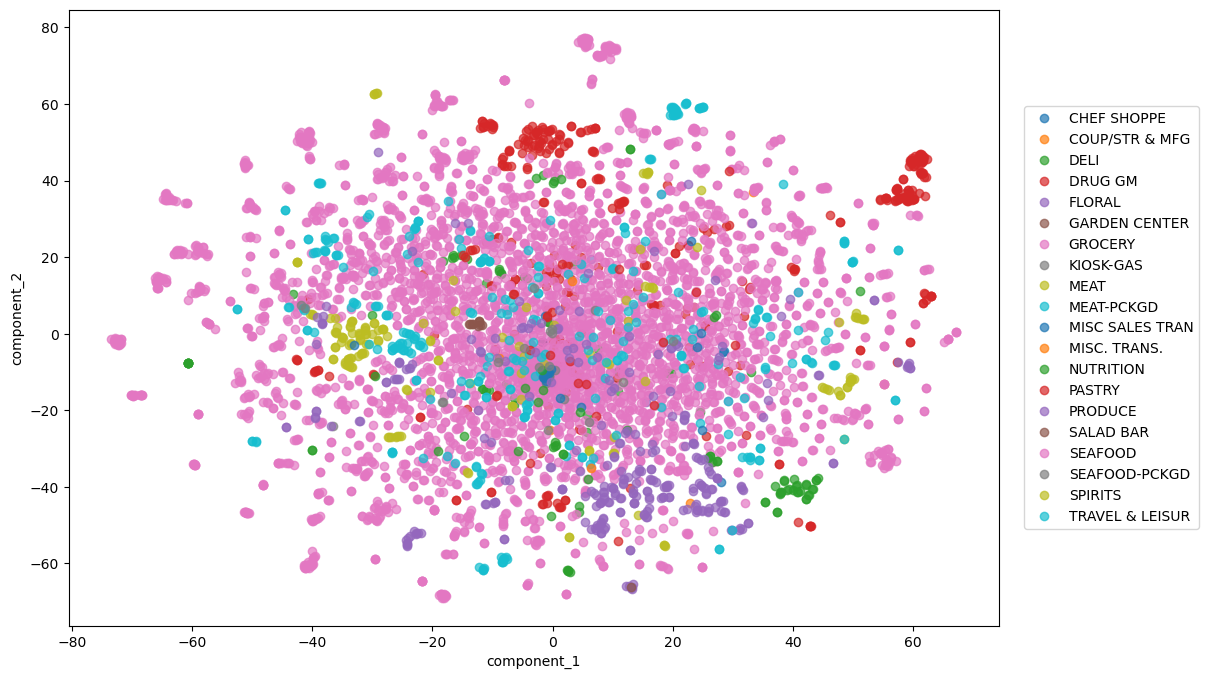

CPU times: total: 2min 32s
Wall time: 24.5 s


In [22]:
%%time
item_emb_tsne = reduce_dims(model.item_factors, dims=2, method='tsne') # 5001 х 100  ---> 5001 x 2
item_emb_tsne['category'] = category  # Добавляем категорию
item_emb_tsne = item_emb_tsne[item_emb_tsne['category'] != 'UNKNOWN']

display_components_in_2D_space(item_emb_tsne, labels='category')

Нарисуем все, кроме GROCERY

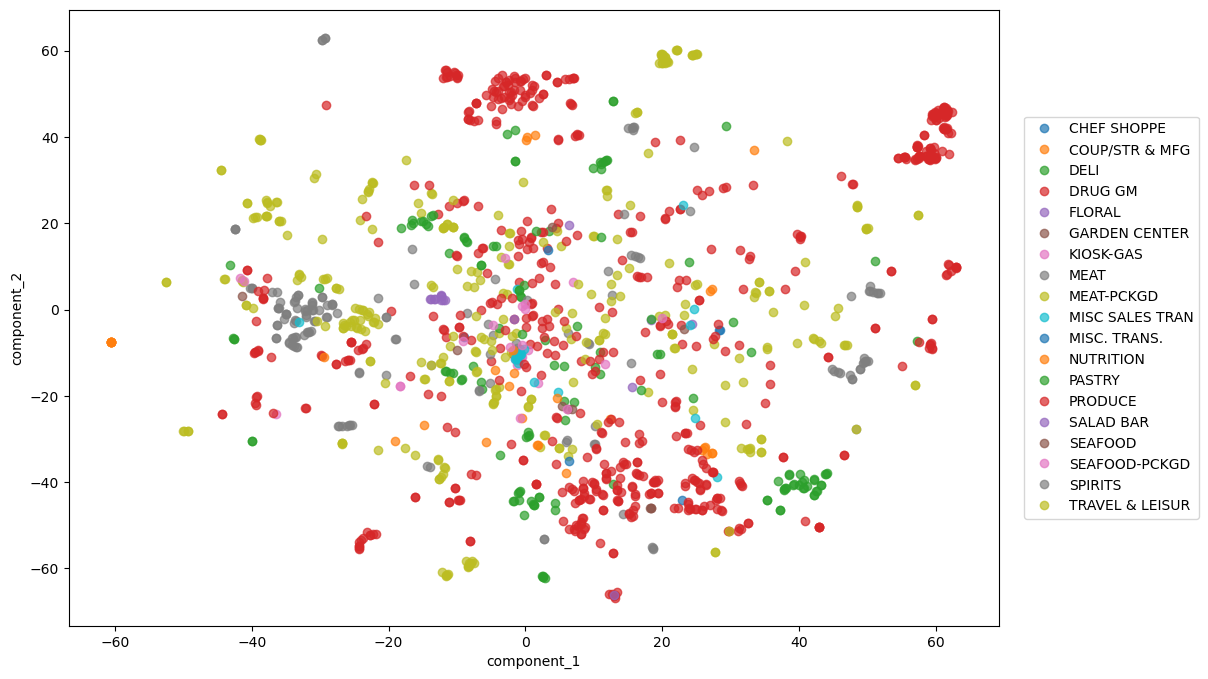

In [23]:
display_components_in_2D_space(item_emb_tsne[item_emb_tsne['category'] != 'GROCERY'], labels='category')

Можно увидеть, что некоторые точки находятся вместе (серые, красные, зеленые). Это значит, что латентное пространство (созданое нами) может неплохо кластеризовать товары по каким-то фичам (в данном случае по категориям).

Нарисуем несколько конкретных категорий

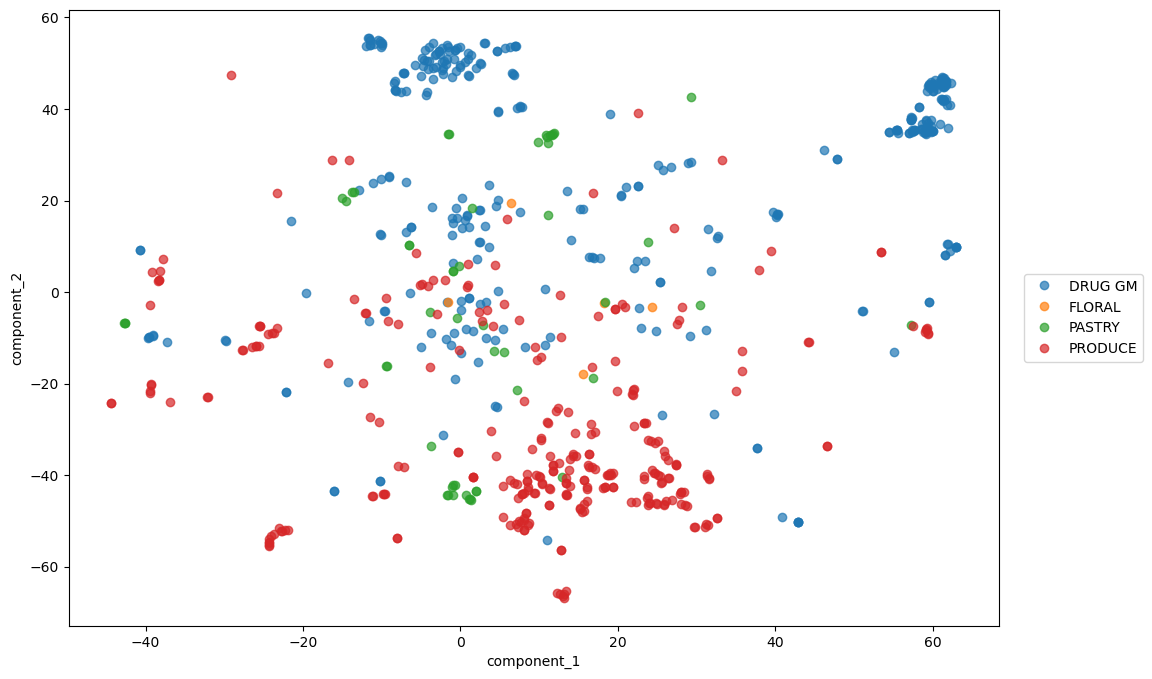

In [24]:
interesting_cats = ['PASTRY', 'PRODUCE', 'DRUG GM', 'FLORAL']

display_components_in_2D_space(item_emb_tsne[item_emb_tsne['category'].isin(interesting_cats)], 
                                             labels='category')

На самом деле, я бы сказал, что **результат средний**:
- Модель выучила похожесть только небольшой части товаров

In [25]:
item_emb_tsne.head(2)

,component_1,component_2,category
0,-0.813251,-10.065058,MISC SALES TRAN
1,-1.170916,-12.785549,KIOSK-GAS


recommend_all делает перемножение, но еще и сортирует и выбирает топ-N

In [26]:
%%time
recommendations = model.recommend_all(N=5, 
                                      user_items=sparse_user_item,
                                      filter_already_liked_items=True, 
                                      filter_items=[itemid_to_id[999999]], 
                                      recalculate_user=True,
#                                       batch_size=500
                                     )

CPU times: total: 3.36 s
Wall time: 724 ms


In [27]:
item_1 = model.item_factors[1]
item_2 = model.item_factors[2]

*Посмотрите также / Похожие товары*

In [28]:
# ближайшие айтемы друг к другу. Указываем вначале айтем, для которого ищем. N - количество ближайших айтемов. 
# поэтому самый похожий на первый айтем - он сам. 1 массив - айтемы, 2 массив - доля схожести.
model.similar_items(1, N=5)

(array([   1,    2, 3932,    5, 4257]),
 array([1.0000002 , 0.75554174, 0.74145687, 0.73987436, 0.72868305],
       dtype=float32))

*Вашим друзьям нравится / Похожим пользователям нравится / ...*

Аналогично с пользователями.

Пользователь --> похожих пользовтелей --> рекомендовать те товары, которые купили похожие юзеры

In [29]:
model.similar_users(userid_to_id[10], N=5)

(array([   9,  239,  354,  790, 1380]),
 array([0.99999994, 0.97546625, 0.9739492 , 0.97343767, 0.9719762 ],
       dtype=float32))

In [30]:
userid_to_id[10]

9

### 2. TF-IDF взвешивание

При взвешивании у частых товаров (пакет, например) значения будут поменьше, а у редких товаров значения будут побольше.

In [31]:
# tfidf_user_item_matrix = tfidf_weight(user_item_matrix.T).T.tocsr()  # Применяется к item-user матрице! 

tfidf_user_item_matrix = tfidf_weight(user_item_matrix).tocsr() 

In [41]:
%%time

model = AlternatingLeastSquares(factors=100, 
                                regularization=0.01,
                                iterations=10, 
                                calculate_training_loss=True, 
                                num_threads=4,
                                random_state=42)

model.fit(tfidf_user_item_matrix,  # На вход item-user matrix
          show_progress=True)

result['als_tfidf'] = result['user_id'].apply(lambda x: get_recommendations(x, model, sparse_user_item, N=5))

result.apply(lambda row: precision_at_k(row['als_tfidf'], row['actual']), axis=1).mean()

  0%|          | 0/10 [00:00<?, ?it/s]

CPU times: total: 17.4 s
Wall time: 3.59 s


0.24005876591576888

Поставили sparse_user_item вместо tfidf_user_item_matrix, поскольку иначе будет ниже точность. Если убрать двойное транспонирование, то будет еще лучше. Почему так? У нас в get_recommendations мы пытаемся заново пересчитать вектор пользователя, но как мы пробуем его пересчитать? Потому что одна матрица взвешенная, а другая нет. И лучше считать на отложенной матрице, где купленный товар это единички. 

А модель пытается предсказать какое-то маленькое число, потому что оно популярное - хуйня какая то...

Взвешивание позволяет лучше раскидать пользователей, лучше отсортировать пользователей, которые похожи между собой. Почему? Потому что, если все покупают пакеты, то это не значит, что все пользователи, которые их купили, - похожи.

А если два человека купили кресло-качалку, то они скорее похожи. И получается, что у таких товаров вес больше становится, а у пакетов меньше. Вот и получается, что обучение на таких данных (взвешенных) лучше. 

Но предсказания лучше на невзвешенных данных. Таким образом. мы повысили метрику.

### 3. BM25 взвешивание

In [33]:
bm25_user_item_matrix = bm25_weight(user_item_matrix.T).T.tocsr()  # Применяется к item-user матрице ! 

In [34]:
%%time

model = AlternatingLeastSquares(factors=100, 
                                regularization=0.001,
                                iterations=10, 
                                calculate_training_loss=True, 
                                num_threads=4,
                                random_state=42) 

model.fit(csr_matrix(bm25_user_item_matrix).tocsr(),  # На вход item-user matrix
          show_progress=True)

result['als_bm25'] = result['user_id'].apply(lambda x: get_recommendations(x, model, sparse_user_item, N=5))

result.apply(lambda row: precision_at_k(row['als_bm25'], row['actual']), axis=1).mean()

  0%|          | 0/10 [00:00<?, ?it/s]

CPU times: total: 16.5 s
Wall time: 3.62 s


0.2246816846229187

Неплохой результат. 

**Таким образом, можно брать и взвешивать матрицу, а после этого делать разложение ALS и можно получить результаты получше.**

При вызове ALS мы также можем оптимизировать гиперпараметры и еще сильнее улучшить результат.

Можно менять factors, iterations, весовую функцию.

In [35]:
# Сохраним результаты метрик.
result.to_csv('predictions_cf.csv', index=False)  # cf - collaborative filtering

## 4. Важно искать оптимальные параметры

- regularization, iterations
- factors
- Вес (элемент в матрице user-item)

-----

# Production

Начиная с этого вебинара, мы будем строить *базовое решение* для системы рекомендаций топ-N товаров. В финальном проекте вам нужно будет его сущесвтенно улучшить.  
  
**Ситуация**: Вы работает data scientist в крупном продуктовом российском ритейлере iFood. Ваш конкурент сделал рекомендательную систему, и его продажи выросли. Ваш менеджмент тоже хочет увеличить продажи   
**Задача со слов менеджера**: Сделайте рекомендательную систему топ-10 товаров для рассылки по e-mail

**Ожидание:**
- Отправляем e-mail с топ-10 товарами, отсортированными по вероятности

**Реальность:**
- Чего хочет менеджер от рекомендательной системы? (рост показателя X на Y% за Z недель)
- По-хорошему надо бы предварительно посчитать потенциальный эффект от рекоммендательной системы (Оценки эффектов у менеджера и у вас могут сильно не совпадать: как правило, вы знаете про данные больше)
- А у нас вообще есть e-mail-ы пользователей? Для скольки %? Не устарели ли они?
- Будем ли использовать СМС и push-уведомления в приложении? Может, будем печатать рекомендации на чеке после оплаты на кассе?
- Как будет выглядеть e-mail? (решаем задачу топ-10 рекомендаций или ранжирования? И топ-10 ли?)
- Какие товары должны быть в e-mail? Есть ли какие-то ограничения (только акции и т п)?
- Сколько денег мы готовы потратить на привлечение 1 юзера? CAC - Customer Aquisition Cost. Обычно CAC = расходы на коммуникацию + расходы на скидки
- Cколько мы хотим зарабатывать с одного привлеченного юзера?
---
- А точно нужно сортировать по вероятности?
- Какую метрику использовать?
- Сколько раз в неделю отпрпавляем рассылку?
- В какое время отправляем рассылку?
- Будем отправлять одному юзеру много раз наши рекоммендации. Как добиться того, чтобы они хоть немного отличались?
- Нужно ли, чтобы в одной рассылке были *разные* товары? Как определить, что товары *разные*? Как добиться того, чтобы они были разными?
- И многое другое:)

**В итоге договорились, что:**
- Хотим повысить выручку минимум на 6% за 4 месяца. Будем повышать за счет роста Retention минимум на  3% и среднего чека минимум на 3%
- Топ-5 товаров, а не топ-10 (В e-mail 10 выглядят не красиво, в push и на чек больше 5 не влязает)
- Рассылаем в e-mail (5% клиентов) и push-уведомлении (20% клиентов), печатаем на чеке (все оффлайн клиенты)
- **3 товара с акцией** (Как это учесть? А если на товар была акция 10%, а потом 50%, что будет стоять в user-item матрице?)
- **1 новый товар** (юзер никогда не покупал. Просто фильтруем аутпут ALS? А если у таких товаров очень маленькая вероятность покупки? Может, использовать другую логику/модель?) 
- **1 товар для роста среднего чека** (товары минимум дороже чем обычно покупает юзер. Как это измерить? На сколько дороже?)

Вопросов стало еще больше. Поэтому сначала делаем **MVP** (Minimum viable product) на e-mail. Показываем его менеджеру, измеряем метрики на юзерах. По фидбеку и метрикам делаем улучшения MVP и раскатываем его на push-уведомления и чеки

*Data Science проект* - итеративный процесс!

In [36]:
data_train.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0


In [37]:
data_train['price'] = data_train['sales_value'] / (np.maximum(data_train['quantity'], 1))
data_train['price'].max()

C:\Temp\ipykernel_6616\1027606932.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_train['price'] = data_train['sales_value'] / (np.maximum(data_train['quantity'], 1))


499.99

In [38]:
# < 1$
data_train['price'].quantile(0.20)

0.99

In [39]:
# > 100$
data_train['price'].quantile(0.99995)

82.01435450003483

In [40]:
def prefilter_items(data):
    # Уберем самые популярные товары (их и так купят)
    popularity = data_train.groupby('item_id')['user_id'].nunique().reset_index() / data_train['user_id'].nunique()
    popularity.rename(columns={'user_id': 'share_unique_users'}, inplace=True)
    
    top_popular = popularity[popularity['share_unique_users'] > 0.5].item_id.tolist()
    data = data[~data['item_id'].isin(top_popular)]
    
    # Уберем самые НЕ популярные товары (их и так НЕ купят)
    top_notpopular = popularity[popularity['share_unique_users'] < 0.01].item_id.tolist()
    data = data[~data['item_id'].isin(top_notpopular)]
    
    # Уберем товары, которые не продавались за последние 12 месяцев
    
    # Уберем не интересные для рекоммендаций категории (department)
    
    # Уберем слишком дешевые товары (на них не заработаем). 1 покупка из рассылок стоит 60 руб. 
    
    # Уберем слишком дорогие товарыs
    
    # ...
    
def postfilter_items(user_id, recommednations):
    pass

Все эти функции отправим затем в *src.utils*

### Домашнее задание

Попробовать поподбирать разные параметры для разных вариантов ALS и посмотреть, где результат оказывается лучше.

---